In [1]:
from truncatedMVN import TruncMVN
import numpy as np


In [2]:
mean = np.random.randn(100)

cov = np.random.randn(100,100)*0.02
cov = cov@cov.T+np.eye(100)*1

In [3]:
np.linalg.det(cov)

50.92356514473597

In [4]:
planes = np.random.randn(800,100)+np.ones([800,100])

In [5]:
class NotFindingEnoughSamplesDueToRejection(ValueError):
    '''raise this when the method tries for ages to find any samples with rejection sampling'''
    
class TruncMVNrejection(TruncMVN):
    def __init__(self,mean,cov,planes,verbose=False):
        """
        Create the truncated MVN. You need to specify the mean and covariance of the multivariate normal (MVN), and
        the normals to the planes that will truncate this MVN. We assume for this version that the planes pass through
        the origin (as this was our use case).
        
        mean = (D) vector: location of the MVN
        cov = (DxD) matrix: covariance of the MVN
        planes = (NxD) matrix, each row a normal to a plane (vector points to 'valid' side of plane)
        
        thinning = how much thinning to do during sampling
        burnin = how many iterations of burnin to have (defaults to number of iterations used to generate samples)
        """
        self.mean = mean.astype(float)
        self.cov = cov.astype(float)
        self.Phi = planes.astype(float)
        self.verbose = verbose

    def sample(self,samples=10):
        """
        Sample from the truncated MVN.
        Parameters:
            samples = number of samples (default 10).
        """
        xs = np.zeros([0,len(self.mean)])
        for it in range(100):
            samps = np.random.multivariate_normal(self.mean,self.cov,1000)
            keep = np.min(self.Phi @ samps.T,0)>0
            xs = np.r_[xs,samps[keep,:]]
            if len(xs)>samples:
                return xs[:samples,:]
        raise NotFindingEnoughSamplesDueToRejection
        
       
        


In [6]:
tm = TruncMVN(mean,cov,planes)

In [8]:
tm.sample(samples=3)

(3, 100)

In [114]:
%timeit -n 1 -r 1 tm.sample(samples=10) #before just one of these samples took over 2 minutes :)

665 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [115]:
samps = np.random.multivariate_normal(tm.mean,tm.cov,10000)

In [116]:
np.sum(np.min((tm.Phi @ samps.T),0)>0)

0

In [117]:
startx = tm.findstartpoint()

(-1.5, 1.5)

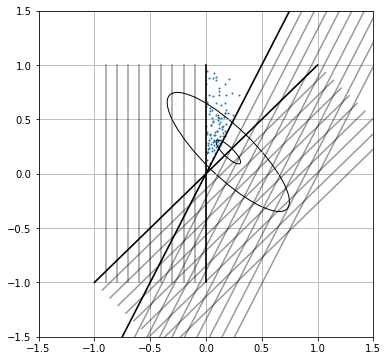

In [14]:
from truncatedMVN import TruncMVNrejection
from truncatedMVN import TruncMVN
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
mean = np.array([0.2,0.2])
cov = np.array([[0.3,-0.25],[-0.25,0.3]])
planes = np.array([[1,0],[-1,1],[-2,1]])
tm = TruncMVN(mean,cov,planes)
plt.figure(figsize=[6,6])
tm.plot(samples=100)
plt.grid()
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])

In [121]:
np.set_printoptions(precision=3,suppress=True)

In [122]:
np.linalg.inv(L) @ cov @ np.linalg.inv(L.T)

array([[1., 0.],
       [0., 1.]])

In [123]:
transformed_planes = planes @ L
transformed_cov = np.eye(len(cov))
transformed_mean = mean @ np.linalg.inv(L.T)

In [124]:
np.linalg.inv(L) @ mean @ np.linalg.inv(L.T)

array([0.667, 5.005])

In [125]:
transformed_planes, transformed_cov, transformed_mean

(array([[ 0.548,  0.   ],
        [-1.004,  0.303],
        [-1.552,  0.303]]),
 array([[1., 0.],
        [0., 1.]]),
 array([0.365, 1.211]))

(-1.5, 1.5)

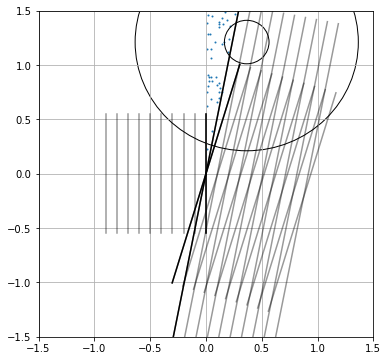

In [126]:
transformed_tm = TruncMVN(transformed_mean,transformed_cov,transformed_planes)
plt.figure(figsize=[6,6])
transformed_tm.plot(samples=100)
plt.grid()
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])

In [134]:
transformed_samples = transformed_tm.sample(samples = 10000)

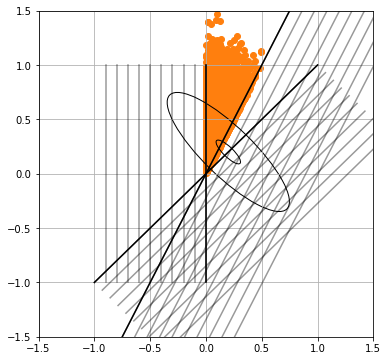

In [135]:
plt.figure(figsize=[6,6])
tm.plot(samples=1)
plt.grid()
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
test_samples = transformed_samples @ L.T
plt.scatter(test_samples[:,0],test_samples[:,1])

In [136]:
normal_samples = tm.sample(samples=10000)

In [137]:
np.mean(normal_samples,0)

array([0.104, 0.494])

In [138]:
np.mean(test_samples,0)

array([0.103, 0.493])

array([1.00452192, 1.00604022])

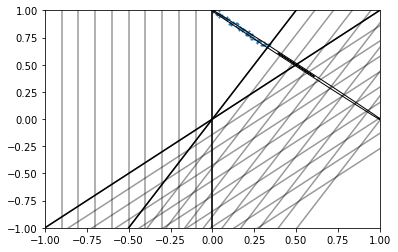

In [18]:
from truncatedMVN import TruncMVN
import numpy as np

class TruncMVNreparam(TruncMVN):
    def __init__(self,mean,cov,planes,thinning=1,burnin=None,verbose=False):
        """
        Create the truncated MVN. You need to specify the mean and covariance of the multivariate normal (MVN), and
        the normals to the planes that will truncate this MVN. We assume for this version that the planes pass through
        the origin (as this was our use case).
        
        mean = (D) vector: location of the MVN
        cov = (DxD) matrix: covariance of the MVN
        planes = (NxD) matrix, each row a normal to a plane (vector points to 'valid' side of plane)
        
        thinning = how much thinning to do during sampling
        burnin = how many iterations of burnin to have (defaults to number of iterations used to generate samples)
        """
        self.L = np.linalg.cholesky(cov)
        self.invL = np.linalg.inv(self.L) #TODO Don't need to invert maybe if we have chole.?
        self.transformed_planes = planes @ self.L
        self.mean = mean.astype(float)
        self.cov = cov.astype(float)
        self.Phi = planes.astype(float)
        self.thinning = thinning
        self.burnin = burnin
        self.verbose = verbose
        self.transformed_cov = np.eye(len(cov))
        self.transformed_mean = mean @ self.invL.T        
        self.TMVN = TruncMVN(self.transformed_mean,self.transformed_cov,self.transformed_planes,thinning=thinning,burnin=burnin,verbose=verbose)
        

    def sample(self,initx=None,samples=10,usecaching=False):
        """
        Sample from the truncated MVN.
        Parameters:
            initx = the start location for sampling, if not set, then the tool tries to find a valid (non-zero/truncated) location
                        close to the MVN's mean.
            samples = number of samples (default 10).
            usecaching = whether to precache samples (the truncnorm rvs method is faster if you ask for lots of samples at once!)
        """
        return self.TMVN.sample(initx=initx,samples=samples,usecaching=usecaching) @ self.L.T
    
import matplotlib.pyplot as plt
%matplotlib inline
mean = np.array([0.5,0.5])
cov = np.array([[0.3,-0.2999],[-0.2999,0.3]])
planes = np.array([[1,0],[-1,1],[-2,1]])
tm = TruncMVNreparam(mean,cov,planes,burnin=10,thinning=1)
tm.plot()
plt.xlim([-1,1])
plt.ylim([-1,1])
tm.compute_gelman_rubin()